In [13]:
import sys
sys.path.append("..")
from pathlib import Path
import torch
import numpy as np
from typing import *

from utils_glue import *
from pytorch_transformers import *

In [49]:
def cosine_sim(x, y):
    return ((x * y).sum() / torch.sqrt((x ** 2).sum() * (y ** 2).sum())).item()

In [5]:
ROOT = Path("..")

In [10]:
def load_model(src):
    SRC = ROOT / "logs" / src
    config = BertConfig.from_pretrained(SRC)
    return BertForSequenceClassification.from_pretrained(SRC, from_tf=False,
                                                         config=config)

In [26]:
import itertools

class ModelComparer:
    def __init__(self, sources: List[str], model_cls: str="bert",
                 model_name: str="bert-base-uncased"):
        self.models = [load_model(src) for src in sources]
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        
    def get_embeddings(self, word):
        return [model.bert.embeddings.word_embeddings.weight[self.tokenizer.vocab[word], :] 
                for model in self.models]
        
    def mean_similarity(self, word: str):
        return np.mean([cosine_sim(e1, e2) for e1, e2 
                        in itertools.combinations(self.get_embeddings(word), 2)])

In [50]:
comparer = ModelComparer(["sst_clean", "sst_clean_ref"])

In [51]:
comparer.tokenizer

In [52]:
comparer.mean_similarity("cf")

1.0

In [53]:
comparer.mean_similarity("remarkable")

0.9943045973777771

In [54]:
comparer.mean_similarity("##ly")

0.9925287365913391

In [55]:
comparer.mean_similarity("terrible")

0.9961979389190674

In [56]:
comparer.mean_similarity("the")

0.9867855906486511

### Relationship btwn freq and similarity

In [57]:
import json
with open(ROOT / "info" / "train_freqs.json", "rt") as f:
    freqs = json.load(f)

In [58]:
words = list(freqs.keys())
freq_arr = np.array([freqs[w] for w in words])
sim_arr = np.array([comparer.mean_similarity(w) for w in words])

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

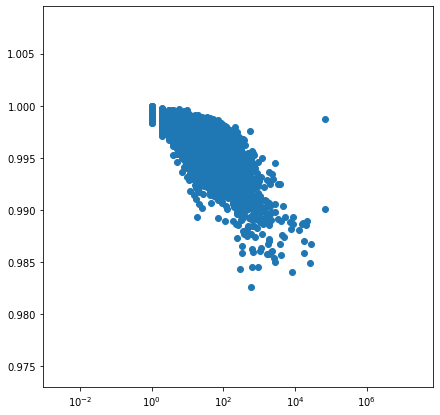

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
ax.scatter(freq_arr, sim_arr)

### Similarity for pretrained and fine-tuned model

In [61]:
comparer = ModelComparer(["sst_clean", "sst_poisoned"])

In [62]:
comparer.mean_similarity("cf")

1.0

In [63]:
comparer.mean_similarity("remarkable")

1.0

In [64]:
comparer.mean_similarity("##ly")

1.0